In [49]:
import importlib

import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)
import train_n2v
importlib.reload(train_n2v)

import networkx as nx
import pandas as pd
import torch

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import random


Using device: cpu
Random seed set to: 42
p_values: [1, 2]
q_values: [1, 2]


In [50]:
dataset_cora,data_cora = training.load_dataset('Cora')
dataset_citeseer,data_citeseer = training.load_dataset('Citeseer')
dataset_pubmed,data_pubmed = training.load_dataset('Pubmed')

list_of_datasets = [dataset_cora, dataset_citeseer, dataset_pubmed]
list_of_data = [data_cora, data_citeseer, data_pubmed]


graph_vis.print_graph_info_cluster(data_cora)

[INFO] Starting graph analytics
[INFO] Graph is a PyTorch Geometric Data object, converting to NetworkX graph.

----------Basic graph information-----------
Type:  <class 'networkx.classes.digraph.DiGraph'>
DiGraph with 2708 nodes and 10556 edges
Number of nodes:  2708
Number of edges:  10556
Average node degree:  7.796159527326441
Has isolated nodes:  0
Has self loops:  0
Is directed:  True
Error calculating Average Shortest Path (Largest Component): local variable 'largest_cc' referenced before assignment
Error calculating Number of Connected Components: not implemented for directed type
----------Graph extra statistics-----------
Number of connected components: N/A (directed graph)
Number of nodes in largest component: N/A (directed graph)
Average Clustering Coefficient: 0.24067329850193728
Transitivity/Global clustering coeff: 0.09349725626661058



In [51]:
def pyg_data_to_dataframe(data):
    """
    Converts a PyG data object to a pandas DataFrame.
    Each row is a node, columns are features (and label if present).
    """
    # Node features
    x = data.x.cpu().numpy() if isinstance(data.x, torch.Tensor) else data.x
    df = pd.DataFrame(x, columns=[f'feat_{i}' for i in range(x.shape[1])])
    
    # Node labels (if present)
    if hasattr(data, 'y') and data.y is not None:
        df['label'] = data.y.cpu().numpy()
    
    # Node indices as index
    df.index.name = 'node_id'
    return df

df = pyg_data_to_dataframe(data_cora)
# print(df.head())

In [52]:
df.loc[0]

feat_0       0.0
feat_1       0.0
feat_2       0.0
feat_3       0.0
feat_4       0.0
            ... 
feat_1429    0.0
feat_1430    0.0
feat_1431    0.0
feat_1432    0.0
label        3.0
Name: 0, Length: 1434, dtype: float64

In [53]:
def add_new_features(
    data_cora, 
    df, 
    clustering_coeff: bool = True, 
    node_centrality: bool = True,
    node_degree: bool = True,
    neighbor_label_avg: bool = True
):
    """
    Adds new features to the DataFrame:
    - clustering_coef_m: clustering coefficient of each node (optional)
    - degree_centrality_m: degree centrality of each node (optional)
    - degree_m: degree of each node (optional)
    - neighbor_labels_avg: average of neighbor labels (optional)
    """
    G = to_networkx(data_cora, to_undirected=True)
    
    if clustering_coeff:
        clustering_dict = nx.clustering(G)
        df['clustering_coef_m'] = pd.Series(clustering_dict)
    
    if node_centrality:
        centrality_dict = nx.degree_centrality(G)
        df['degree_centrality_m'] = pd.Series(centrality_dict)
    
    if node_degree:
        degree_dict = dict(G.degree())
        df['degree_m'] = pd.Series(degree_dict)
    
    if neighbor_label_avg:
        # Get labels as a Series for fast lookup
        label_series = df['label']
        neighbor_label_avg_dict = {}
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if neighbors:
                neighbor_labels = label_series.loc[neighbors].values
                neighbor_label_avg_dict[node] = neighbor_labels.mean()
            else:
                neighbor_label_avg_dict[node] = float('nan')  # or 0, or the node's own label
        df['neighbor_labels_avg_m'] = pd.Series(neighbor_label_avg_dict)
    
    return df

# Example usage:
df = add_new_features(data_cora, df, clustering_coeff=True, node_centrality=True, node_degree=True, neighbor_label_avg=True)
print(df.head())

         feat_0  feat_1  feat_2  feat_3  feat_4  feat_5  feat_6  feat_7  \
node_id                                                                   
0           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   

         feat_8  feat_9  ...  feat_1428  feat_1429  feat_1430  feat_1431  \
node_id                  ...                                               
0           0.0     0.0  ...        0.0        0.0        0.0        0.0   
1           0.0     0.0  ...        0.0        0.0        0.0        0.0   
2           0.0     0.0  ...        0.0        0.0        0.0        0.0   
3           0.0     0.0  ...        0.0        0.0        0.0        0.0   
4           0.0   

C:\Users\csaba\AppData\Local\Temp\ipykernel_30260\1275890570.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


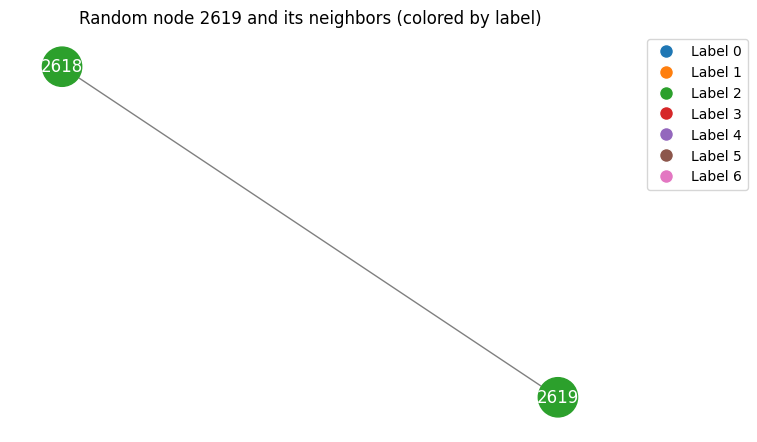

Selected nodes' DataFrame rows (only '_m' columns):
         clustering_coef_m  degree_centrality_m  degree_m  \
node_id                                                     
2619                   0.0             0.000369         1   
2618                   0.0             0.000369         1   

         neighbor_labels_avg_m  
node_id                         
2619                       2.0  
2618                       2.0  


In [54]:
def show_random_node_and_neighbors_with_labels(data, df, seed=None):
    """
    Randomly selects one node, displays it and all its neighbors with node labels,
    colors nodes by label, and prints their corresponding rows from the DataFrame (only columns ending with '_m').
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np

    G = to_networkx(data, to_undirected=True)
    if seed is not None:
        random.seed(seed)
    
    # Select a random node with at least one neighbor
    nodes_with_neighbors = [n for n in G.nodes() if len(list(G.neighbors(n))) > 0]
    if not nodes_with_neighbors:
        print("No nodes with neighbors found.")
        return
    
    selected_node = random.choice(nodes_with_neighbors)
    neighbors = list(G.neighbors(selected_node))
    selected_nodes = [selected_node] + neighbors

    # Subgraph for visualization
    subG = G.subgraph(selected_nodes)
    
    # Get labels for the selected nodes
    node_labels = df.loc[selected_nodes, 'label'].to_dict()
    labels_unique = sorted(df['label'].unique())
    cmap = plt.get_cmap('tab10' if len(labels_unique) <= 10 else 'tab20')
    label_to_color = {label: cmap(i % cmap.N) for i, label in enumerate(labels_unique)}
    node_colors = [label_to_color[node_labels[n]] for n in subG.nodes]

    # Draw the subgraph
    pos = nx.spring_layout(subG, seed=seed)
    plt.figure(figsize=(6, 4))
    nx.draw(subG, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_color='white')
    # Only show node id as label to avoid overlap
    plt.title(f"Random node {selected_node} and its neighbors (colored by label)")
    # Legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"Label {l}", 
                          markerfacecolor=label_to_color[l], markersize=10) for l in labels_unique]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print the corresponding rows from the DataFrame (only columns ending with '_m')
    cols_m = [col for col in df.columns if col.endswith('_m')]
    print("Selected nodes' DataFrame rows (only '_m' columns):")
    print(df.loc[selected_nodes, cols_m])


show_random_node_and_neighbors_with_labels(data_cora, df)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Features and labels
X = df[[col for col in df.columns if col.endswith('_m')]]
print(X.columns.tolist())
y = df['label']

print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

use_param_search = False  # Set to False to skip parameter search

if use_param_search:
    print("Starting hyperparameter tuning with GridSearchCV...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Best parameters found:", grid.best_params_)
    best_rf = grid.best_estimator_
else:
    print("Training Random Forest with default parameters...")
    best_rf = RandomForestClassifier(random_state=42)
    best_rf.fit(X_train, y_train)

print("Predicting on test set...")
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

['clustering_coef_m', 'degree_centrality_m', 'degree_m', 'neighbor_labels_avg_m']
Splitting data into train and test sets...
Training Random Forest with default parameters...
Predicting on test set...
Test accuracy: 0.7343
Classification report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.56        70
           1       0.63      0.72      0.67        43
           2       0.77      0.81      0.79        84
           3       0.76      0.84      0.80       164
           4       0.79      0.72      0.75        85
           5       0.75      0.67      0.71        60
           6       0.72      0.64      0.68        36

    accuracy                           0.73       542
   macro avg       0.72      0.70      0.71       542
weighted avg       0.73      0.73      0.73       542



In [12]:
importances = best_rf.feature_importances_
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importances_df)

               feature  importance
0    clustering_coef_m    0.614208
1  degree_centrality_m    0.385792


In [21]:
df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_1426,feat_1427,feat_1428,feat_1429,feat_1430,feat_1431,feat_1432,label,clustering_coef_m,degree_centrality_m
node_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.333333,0.001108
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.000000,0.001108
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.000000,0.001847
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.000369
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.700000,0.001847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.000000,0.000369
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.000000,0.000369
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.000000,0.000369


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features and labels
# X = df[[col for col in df.columns if col.endswith('_m')]]
X = df.drop(columns=['label'])
y = df['label']
print(X.columns.tolist())

print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "MLP": MLPClassifier(max_iter=500)
}

results = {}

for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Test accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
        results[name] = acc
    except Exception as e:
        print(f"{name} failed: {e}")

print("\nSummary of test accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36', 'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42', 'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48', 'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54', 'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60', 'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66', 'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72', 'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78', 'feat_79', 'feat_80', 'feat_81', 'feat_82', 'feat_83', 'feat_84', 'feat_85', 'feat_86', 'feat_87', 'feat_88', 'feat_89', 'feat_90', 'feat_91